In [1]:
#%pip install python-Levenshtein
import Levenshtein as levenshtein

In [2]:
import math
import os
import time
import wget
import random
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, rnn
from mxnet.gluon.data import ArrayDataset, DataLoader
import string
import tarfile
import urllib
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
import cv2
import numpy as np
import _pickle as cPickle
import re
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import pickle
import glob
import matplotlib.gridspec as gridspec
%matplotlib inline
from skimage import transform as skimage_tf
from skimage import exposure
np.seterr(all='raise')

import multiprocessing
mx.random.seed(1)
from mxboard import SummaryWriter


<h3>Pre Processing</h3>

In [3]:
import matplotlib as plt
import os
import PIL
import pathlib

image_dir = "/restricted/projectnb/cs501t2/minglan/words/"

image_dir = pathlib.Path(image_dir) 
image_count = len(list(image_dir.glob('*.png')))
print("Total number of images = ", image_count)

Total number of images =  791


In [4]:
MAX_IMAGE_SIZE_WORD = (60, 800)
def resize_image(image, desired_size):
    ''' Helper function to resize an image while keeping the aspect ratio.
    Parameter
    ---------
    
    image: np.array
        The image to be resized.
    desired_size: (int, int)
        The (height, width) of the resized image
    Return
    ------
    image: np.array
        The image of size = desired_size
    bounding box: (int, int, int, int)
        (x, y, w, h) in percentages of the resized image of the original
    '''
    size = image.shape[:2]
    if size[0] > desired_size[0] or size[1] > desired_size[1]:
        ratio_w = float(desired_size[0])/size[0]
        ratio_h = float(desired_size[1])/size[1]
        ratio = min(ratio_w, ratio_h)
        new_size = tuple([int(x*ratio) for x in size])
        image = cv2.resize(image, (new_size[1], new_size[0]))
        size = image.shape
            
    delta_w = max(0, desired_size[1] - size[1])
    delta_h = max(0, desired_size[0] - size[0])
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
            
    color = image[0][0]
    if color < 230:
        color = 230
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
    crop_bb = (left/image.shape[1], top/image.shape[0], (image.shape[1] - right - left)/image.shape[1],
               (image.shape[0] - bottom - top)/image.shape[0])
    return image, crop_bb

def _pre_process_image(img_in):
    im = cv2.imread(img_in, cv2.IMREAD_GRAYSCALE)
    if np.size(im) == 1: # skip if the image data is corrupt.
        return None
    # reduce the size of form images so that it can fit in memory.
    im, _ = resize_image(im, MAX_IMAGE_SIZE_WORD)
    img_arr = np.asarray(im)
    return img_arr 

<h3> Load Data </h3>

In [5]:
from mxnet.gluon.data import dataset

image_data_file_name = "image_data-word-text-word.plk"
DATA_FOLDER = "/restricted/projectnb/cs501t2/minglan/words/"
images_names = []
error_count = 0
#     image_files = glob.glob(DATA_FOLDER + '/**/*.png', recursive=True)
image_files = glob.glob(DATA_FOLDER + '*.png')
for filepath in image_files:
    try:
        images_names.append(filepath.split('/')[-1].split('.')[0])
    except:
        error_count += 1
random.shuffle(images_names)
split = 0.8
train_subjects = images_names[:int(split*len(images_names))]
test_subjects = images_names[int(split*len(images_names)):]

In [6]:
class IAMDataSet(dataset.ArrayDataset):
    def __init__(self, train=True): 
        images_data = []
        f = open('/restricted/projectnb/cs501t2/minglan/words.txt')
        for line in f:
            if not line or line[0] == '#':
                continue
            lineSplit = line.strip().split(' ')
            assert len(lineSplit) >= 9
            tmp_id = lineSplit[0]
            image_filename = os.path.join(DATA_FOLDER, tmp_id + ".png")
#             print("image_filename: " + image_filename)
            image_arr = _pre_process_image(image_filename)
            output_data = []
            output_data.append(' '.join(lineSplit[8:]))
            if image_arr is None:
                continue
            images_data.append([tmp_id, image_arr, output_data])
        
        #images_data[lineSplit[0]].append(' '.join(lineSplit[8:]))
        images_data = pd.DataFrame(images_data, columns=["subject", "image", "output"])
        images_data.to_pickle(image_data_file_name, protocol=2)
        train_data = images_data[np.in1d(images_data["subject"], train_subjects)]
        test_data = images_data[np.in1d(images_data["subject"], test_subjects)]
        if train: 
#             print(train_data.shape)
            super(IAMDataSet, self).__init__(train_data)
        else: 
            super(IAMDataSet, self).__init__(test_data)

    def __getitem__(self, idx):
        return (self._data[0].iloc[idx].image, self._data[0].iloc[idx].output)

<h3> Create Dataset </h3>

In [7]:
SEQ_LEN = 32
BATCH_SIZE = 64

In [8]:
# def transform(image, label):
#     image = np.expand_dims(image, axis=0).astype(np.float32)/255.
#     label_encoded = np.zeros(SEQ_LEN, dtype=np.float32)-1
#     for i, letter in enumerate(label[0]):
#         if i >= SEQ_LEN:
#             break
#         label_encoded[i] = alphabet_dict[letter]
    
#     return image, label_encoded
def transform(image, label):
    '''
    This function resizes the input image and converts so that it could be fed into the network.
    Furthermore, the label (text) is one-hot encoded.
    '''
    image = np.expand_dims(image, axis=0).astype(np.float32)
    if image[0, 0, 0] > 1:
        image = image/255.
    image = (image - 0.942532484060557) / 0.15926149044640417
    label_encoded = np.zeros(max_seq_len, dtype=np.float32)-1
    i = 0
    for word in label:
        word = word.replace("&quot", r'"')
        word = word.replace("&amp", r'&')
        for letter in word:
            label_encoded[i] = alphabet_dict[letter]
            i += 1
    return image, label_encoded

<h1> Model </h1> 

In [9]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

In [10]:
!pip install mxboard

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.7.9/install/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode 

In [12]:
alphabet_encoding = r' !"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
alphabet_dict = {alphabet_encoding[i]:i for i in range(len(alphabet_encoding))}

In [13]:
checkpoint_dir = "/restricted/projectnb/cs501t2/minglan/models/"

<h1>Train</h1>

In [14]:
learning_rate = 0.0001
lr_period = 30
lr_scale  = 1
print_every_n = 5
save_every_n = 10
send_image_every_n = 20

In [15]:
def run_epoch(e, network, dataloader, trainer, log_dir, print_name, update_network, save_network):
    total_loss = nd.zeros(1, ctx)
    for i, (x, y) in enumerate(dataloader):
        x = x.as_in_context(ctx)
#         print(x)
        y = y.as_in_context(ctx)
#         print(y)
        with autograd.record():
            output = network(x)
            loss_ctc = ctc_loss(output, y)

        if update_network:
            loss_ctc.backward()
            trainer.step(x.shape[0])
        
        if i == 0 and e % send_image_every_n == 0 and e > 0:
            predictions = output.softmax().topk(axis=2).asnumpy()
            decoded_text = decode(predictions)
            image = x.asnumpy()
            image = image * 0.15926149044640417 + 0.942532484060557            
            output_image = draw_text_on_image(image, decoded_text)
            print("{} first decoded text = {}".format(print_name, decoded_text[0]))
            with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
                sw.add_image('bb_{}_image'.format(print_name), output_image, global_step=e)
        nd.waitall()

        total_loss += loss_ctc.mean()

    epoch_loss = float(total_loss.asscalar())/len(dataloader)

    with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {print_name: epoch_loss}, global_step=e)

    if save_network and e % save_every_n == 0 and e > 0:
        network.save_params("{}/{}".format(checkpoint_dir, checkpoint_name))

    return epoch_loss

In [16]:
def augment_transform(image, label):
    '''
    This function randomly:
        - translates the input image by +-width_range and +-height_range (percentage).
        - scales the image by y_scaling and x_scaling (percentage)
        - shears the image by shearing_factor (radians)
    '''

    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)

    sx = random.uniform(1. - random_y_scaling, 1. + random_y_scaling)
    sy = random.uniform(1. - random_x_scaling, 1. + random_x_scaling)

    s = random.uniform(-random_shearing, random_shearing)

    st = skimage_tf.AffineTransform(scale=(sx, sy),
                                    shear=s,
                                    translation=(tx*image.shape[1], ty*image.shape[0]))
    augmented_image = skimage_tf.warp(image, st, cval=1.0)
    return transform(augmented_image*255., label)

In [17]:
def draw_text_on_image(images, text):
    output_image_shape = (images.shape[0], images.shape[1], images.shape[2] * 2, images.shape[3])  # Double the output_image_shape to print the text in the bottom
    
    output_images = np.zeros(shape=output_image_shape)
    for i in range(images.shape[0]):
        white_image_shape = (images.shape[2], images.shape[3])
        white_image = np.ones(shape=white_image_shape)*1.0
        text_image = cv2.putText(white_image, text[i], org=(5, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=0.0, thickness=1)
        output_images[i, :, :images.shape[2], :] = images[i]
        output_images[i, :, images.shape[2]:, :] = text_image
    return output_images

In [18]:
train_ds = IAMDataSet(train=True)
print("Number of training samples: {}".format(len(train_ds)))
test_ds = IAMDataSet(train=False)
print("Number of testing samples: {}".format(len(test_ds)))

Number of training samples: 632
Number of testing samples: 159


In [19]:
train_ds[0]

(array([[234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234],
        ...,
        [234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234],
        [234, 234, 234, ..., 234, 234, 234]], dtype=uint8),
 ['Actinidia arguta'])

In [21]:
train_data = gluon.data.DataLoader(train_ds.transform(augment_transform), BATCH_SIZE, shuffle=True, last_batch="discard")
test_data = gluon.data.DataLoader(test_ds.transform(transform), BATCH_SIZE, shuffle=False, last_batch="discard")#, num_workers=4)

random_x_translation = 0.03
random_y_translation = 0.03
random_x_scaling = 0.10
random_y_scaling = 0.1
random_shearing = 0.5
max_seq_len = 32

In [22]:
# for x,y in train_data:
#     print(x)
#     print(y)
#     break

In [23]:
net = HandwritingRecognitionNet(rnn_hidden_states=512,rnn_layers=2, ctx=ctx, max_seq_len=160)
net.load_parameters("models/handwriting_line8.params", ctx=ctx)
net.hybridize()

In [24]:
checkpoint_name = "handwriting_line.params"
schedule = mx.lr_scheduler.FactorScheduler(step=lr_period, factor=lr_scale)
schedule.base_lr = learning_rate
ctc_loss = gluon.loss.CTCLoss()

trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, "lr_scheduler": schedule, 'clip_gradient': 2})
log_dir = "/restricted/projectnb/cs501t2/minglan/logs"


In [25]:
epochs = 100
loss_train = []
loss_test = []
for e in range(epochs):
    train_loss = run_epoch(e, net, train_data, trainer, log_dir, print_name="train", update_network=True, save_network=True)
    test_loss = run_epoch(e, net, test_data, trainer, log_dir, print_name="test", \
                          update_network=False, save_network=False)
    loss_train.append(train_loss)
    loss_test.append(test_loss)
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

Epoch 5, train_loss 25.722319, test_loss 28.950094


/share/pkg.7/mxnet/1.7.0/install/lib/SCC/../python3.7-gpu/site-packages/mxnet/gluon/block.py:462: UserWarning: save_params is deprecated. Please use save_parameters. Note that if you want load from SymbolBlock later, please use export instead. For details, see https://mxnet.apache.org/tutorials/gluon/save_load_params.html
  warnings.warn("save_params is deprecated. Please use save_parameters. "


Epoch 10, train_loss 19.672482, test_loss 23.387917
Epoch 15, train_loss 16.453188, test_loss 20.461409
train first decoded text = Alllim schoenoprasu
test first decoded text = Sambucus canadensis
Epoch 20, train_loss 13.743091, test_loss 18.498945
Epoch 25, train_loss 12.061693, test_loss 17.425346
Epoch 30, train_loss 10.484405, test_loss 16.719978
Epoch 35, train_loss 9.373567, test_loss 16.035009
train first decoded text = solidags
test first decoded text = Sambucus Canadensis
Epoch 40, train_loss 8.192978, test_loss 15.498623
Epoch 45, train_loss 7.541565, test_loss 14.908926
Epoch 50, train_loss 6.673493, test_loss 14.948702
Epoch 55, train_loss 6.249042, test_loss 14.783789
train first decoded text = Ace
test first decoded text = Sambucus canadensis
Epoch 60, train_loss 5.515146, test_loss 14.644998
Epoch 65, train_loss 4.871694, test_loss 14.868935
Epoch 70, train_loss 3.992592, test_loss 14.576623
Epoch 75, train_loss 3.951075, test_loss 14.516824
train first decoded text = am

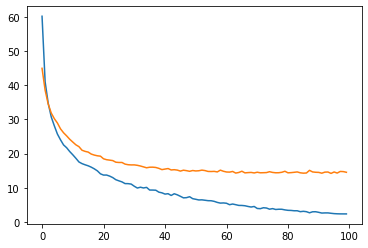

In [28]:
import matplotlib.pyplot as plt
plt.plot(loss_train)
plt.plot(loss_test)